In [28]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Union
import multiprocessing as mp
from functools import partial

import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# from .autoencoder import AutoEncoder
import src

%load_ext autoreload
%autoreload 2

In [6]:
HOME_DIR, BASE_DIR, CODE_DIR, TB_DIR, RMS_DATA_DIR = src.config_paths()

In [7]:
# Setup Tensorflow
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print('Num GPUs Available: ', len(gpus))
    try:
        # Limit memory usage to 5GB of the first GPU (if available)
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]
        )
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), 'Physical GPUs,', len(logical_gpus), 'Logical GPUs')
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)
else:
    print('No GPUs Available')

# tf.config.set_visible_devices([], 'GPU')

No GPUs Available


In [8]:
exp = 'Test 19'
exp_data = src.load(exp)
exp_data

Test No: 19
Date: 2024-08-05
Data: ..\..\AE\Testing\24_08_05_weartest_D1.3_#1000
No. Files: AE-140 NC4-141

In [10]:
FFT_RES = 1000

# Check if exp has fft data
if FFT_RES in exp_data.ae.fft.keys():
    ffts = pd.DataFrame(exp_data.ae.fft[1000])
else:
    ffts = np.zeros((len(exp_data.ae._files), int(1e6/FFT_RES)))
    for i in range(len(exp_data.ae._files)):
        ffts[i, :] = exp_data.ae._fftcalc(i, FFT_RES)
    ffts = exp_data.ae.volt2db(np.array(ffts))
    ffts = pd.DataFrame(ffts)
# ffts.drop([0, 1, 2], axis=0, inplace=True)
ffts.shape

(140, 1000)

Text(0, 0.5, 'Amplitude (dB)')

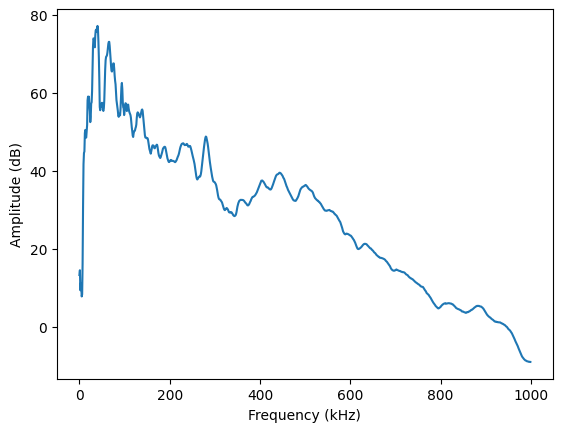

In [11]:
plt.plot(ffts.iloc[11, :])
plt.xlabel('Frequency (kHz)')
plt.ylabel('Amplitude (dB)')

In [95]:
def pre_process(data: np.array, ind: (tuple, tuple)):
    ind_tr, ind_val = ind

    ind_tr, ind_te = train_test_split(ind_tr,
                                      test_size=0.2,
                                    #   random_state=42,
                                      )
    scaler = MinMaxScaler()
    scaler.fit(data[ind_tr, :].reshape(-1, 1))
    data_sc = scaler.transform(data.reshape(-1, 1)).reshape(data.shape)

    x_train = data_sc[ind_tr, :]
    x_val = data_sc[ind_val, :]
    x_test = data_sc[ind_te, :]
    return x_train, x_test, x_val, data_sc

In [96]:
TRAIN_STOP = 120

x_train, x_test, x_val, data_sc = pre_process(ffts.values,
                                              (range(TRAIN_STOP),
                                               range(TRAIN_STOP, ffts.shape[0])
                                               ),
                                              )

In [97]:
autoe = AutoEncoder(x_train.shape[1],
                    latent_dim= 2,
                    n_size=[64, 32],
                    dropout=0.2,
                    )
autoe.build_graph().summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1000)]            0         
                                                                 
 encoder (Functional)        (None, 2)                 66210     
                                                                 
 decoder (Functional)        (None, 1000)              67208     
                                                                 
Total params: 133,418
Trainable params: 133,418
Non-trainable params: 0
_________________________________________________________________


In [98]:
autoe.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),)

In [99]:
history = autoe.fit(x_train, x_train,
                    validation_data=(x_test, x_test),
                    epochs=500,
                    batch_size=32,
                    )

Epoch 1/500


3/3 [==============================] - 0s 67ms/step - loss: 0.2103 - val_loss: 0.2119
Epoch 2/500
3/3 [==============================] - 0s 34ms/step - loss: 0.2098 - val_loss: 0.2115
Epoch 3/500
3/3 [==============================] - 0s 35ms/step - loss: 0.2093 - val_loss: 0.2106
Epoch 4/500
3/3 [==============================] - 0s 25ms/step - loss: 0.2082 - val_loss: 0.2094
Epoch 5/500
3/3 [==============================] - 0s 52ms/step - loss: 0.2072 - val_loss: 0.2077
Epoch 6/500
3/3 [==============================] - 0s 23ms/step - loss: 0.2055 - val_loss: 0.2061
Epoch 7/500
3/3 [==============================] - 0s 25ms/step - loss: 0.2036 - val_loss: 0.2040
Epoch 8/500
3/3 [==============================] - 0s 19ms/step - loss: 0.2012 - val_loss: 0.2015
Epoch 9/500
3/3 [==============================] - 0s 18ms/step - loss: 0.1991 - val_loss: 0.1986
Epoch 10/500
3/3 [==============================] - 0s 20ms/step - loss: 0.1956 - val_loss: 0.1953
Epoch 11/500
3/3 [=============

Text(0.5, 0, 'Epoch')

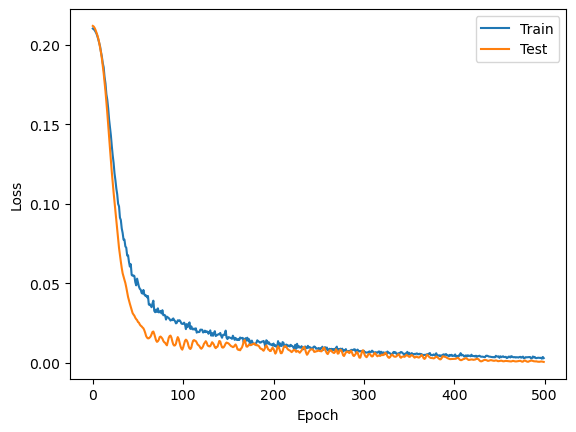

In [100]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='Train')
ax.plot(history.history['val_loss'], label='Test')
ax.legend()
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')

In [101]:
predictions = autoe.predict(data_sc)

recon_scores = mean_squared_error(data_sc.T, predictions.T, multioutput='raw_values')

7/7 [==============================] - 0s 3ms/step


In [102]:
def pred_plot(i: Union[int, list], input, pred):
    fig, ax = plt.subplots(1, len(i), constrained_layout=True, figsize=(15, 5))
    try:
        ax = ax.ravel()
    except AttributeError:
        ax = [ax]

    for ind in range(len(i)):
        ax[ind].plot(input[i[ind], :], label='Original')
        ax[ind].plot(pred[i[ind], :], label='Reconstructed')
        ax[ind].set_ylabel('Normalised PSD')
        ax[ind].set_xlabel('Freqency Bin')
        ax[ind].set_title(f'AUTOE Reconstruction of PSD {i[ind]}')
    lines, labels = ax[0].get_legend_handles_labels()
    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=len(lines))

    return fig, ax

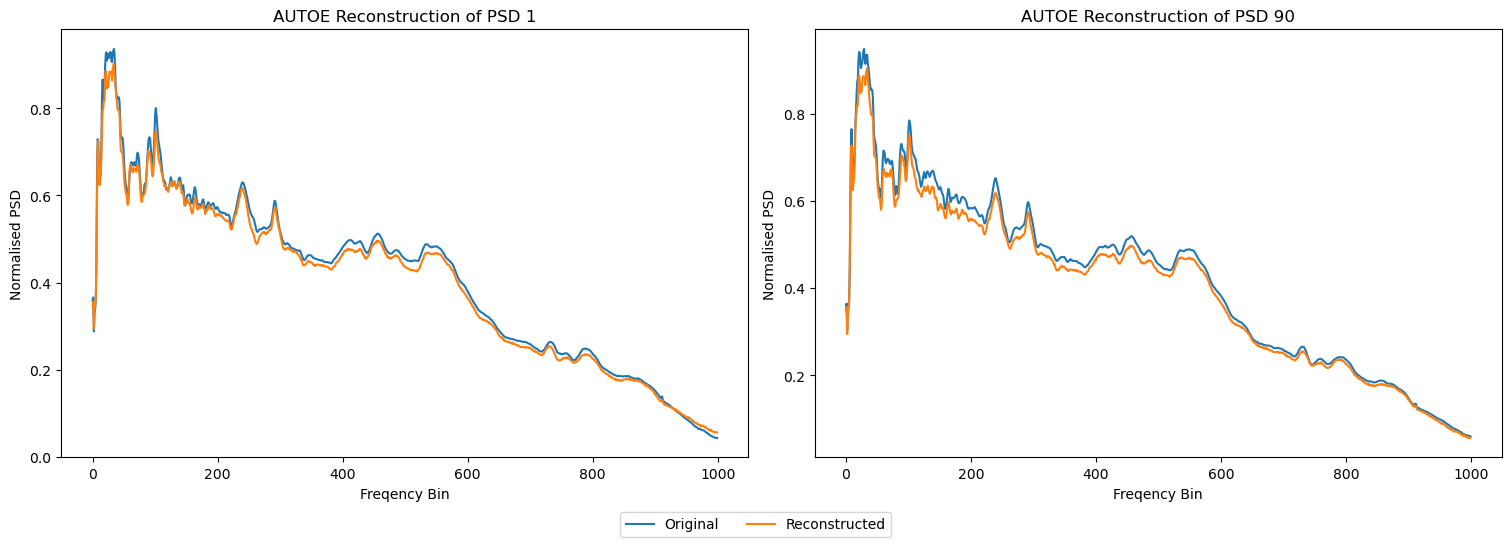

In [103]:
i = [1, 90]
pred_plot(i, data_sc, predictions)
plt.show()

In [104]:
def reject_outliers(data, m = 10):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return data[s<m]

In [105]:
def fit_poly(x, y, deg=None):
    if deg is None:
        deg = [1, 2, 3, 4, 5]
    else:
        deg = [deg]

    # find best degree based on MSE
    mse = 1
    for d in deg:
        cf = np.polyfit(x, y, d)
        p = np.polyval(cf, x)
        m = mean_squared_error(y, p)
        if m < mse:
            cf_out = cf
            mse = m
    return cf_out

In [106]:
y = recon_scores
# remove outliers
y = reject_outliers(recon_scores)

x = np.arange(len(y))

In [16]:
runout = exp_data.features['Runout'] * 1000
form_error = exp_data.features['Form error'] * 1000
mean_rad = exp_data.features['Mean radius']
wear = np.abs(mean_rad - mean_rad.iloc[0])

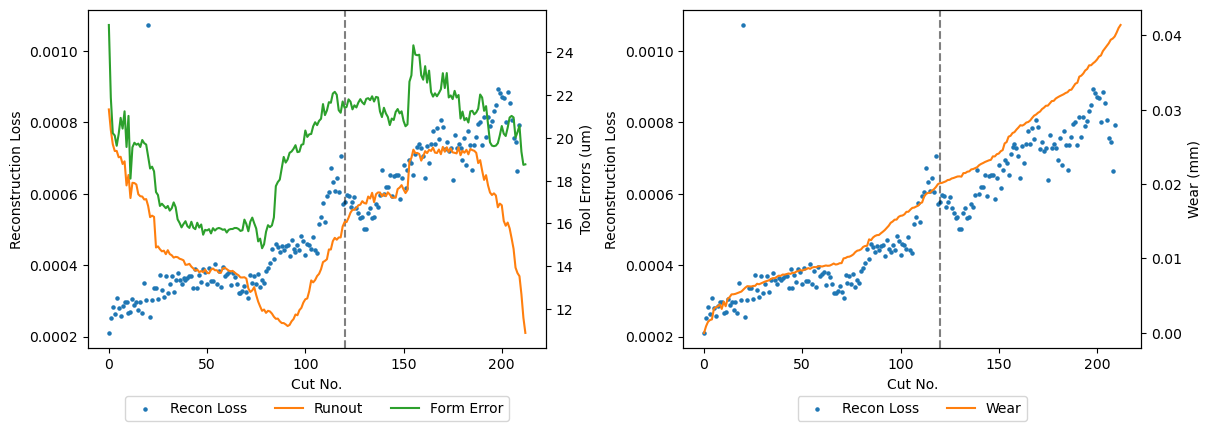

In [107]:
runout = exp_data.features['Runout'] * 1000
form_error = exp_data.features['Form error'] * 1000
mean_rad = exp_data.features['Mean radius']
wear = np.abs(mean_rad - mean_rad.iloc[0])

# line of best fit
cf  = fit_poly(x, y, 1)
lbf = np.polyval(cf, x)


fig, ax = plt.subplots(1, 2, figsize=(12, 4.2), constrained_layout=True)
ax[0].scatter(x,
              y,
              s=5,
              label='Recon Loss',
              )
# ax[0].plot(lbf, 'k--', alpha=0.5)
ax[0].axvline(TRAIN_STOP,
            color='k',
            linestyle='--',
            alpha=0.5,
            )
ax2 = ax[0].twinx()
ax2.plot(runout, 'C1', label='Runout')
ax2.plot(form_error, 'C2', label='Form Error')

ax[0].set_ylabel('Reconstruction Loss')
ax2.set_ylabel('Tool Errors (um)')
ax[0].set_xlabel('Cut No.')

lines, labels = ax[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax[0].legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=len(lines+lines2))

# wear plot
ax[1].scatter(x,
              y,
              s=5,
              label='Recon Loss',
              )
# ax[1].plot(lbf, 'k--', alpha=0.5)
ax[1].axvline(TRAIN_STOP,
            color='k',
            linestyle='--',
            alpha=0.5,
            )
ax3= ax[1].twinx()
ax3.plot(wear, 'C1', label='Wear')

ax[1].set_ylabel('Reconstruction Loss')
ax3.set_ylabel('Wear (mm)')
ax[1].set_xlabel('Cut No.')

lines, labels = ax[1].get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
ax[1].legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=len(lines+lines2))

# ax[0].set_ylim(0.000, 0.0012)
# ax[1].set_ylim(0.000, 0.0012)

plt.show()

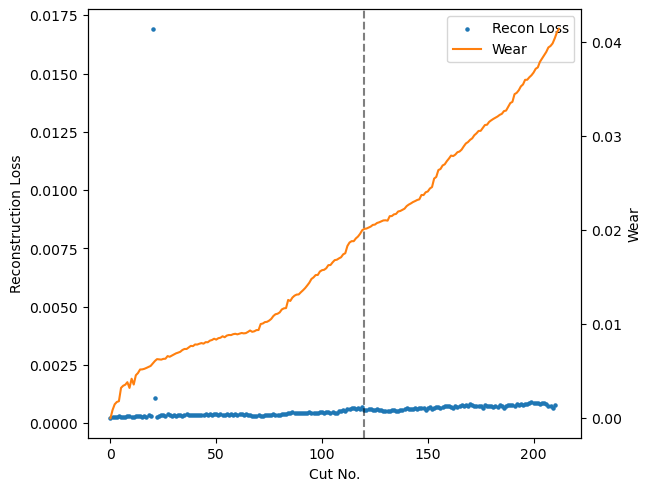

In [108]:
# wear plot
mean_rad = exp_data.features['Mean radius']
wear = np.abs(mean_rad - mean_rad[0])


fig, ax = plt.subplots(constrained_layout=True)
ax.scatter(range(len(recon_scores)),
            recon_scores,
            s=5,
            label='Recon Loss',
            )
ax.axvline(TRAIN_STOP,
            color='k',
            linestyle='--',
            alpha=0.5,
            )
ax2 = ax.twinx()
ax2.plot(wear, 'C1', label='Wear')

ax.set_ylabel('Reconstruction Loss')
ax2.set_ylabel('Wear')
ax.set_xlabel('Cut No.')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# fig.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(1, 1))
ax.legend(lines + lines2, labels + labels2, loc='best')
plt.show()

7/7 [==============================] - 0s 2ms/step


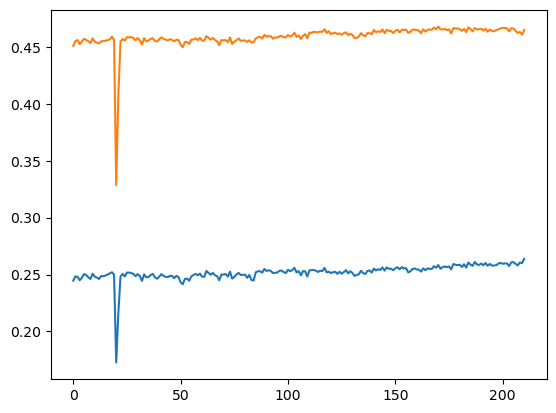

In [109]:
encoder = autoe.get_layer('encoder')
en_data = encoder.predict(data_sc)
plt.plot(en_data)

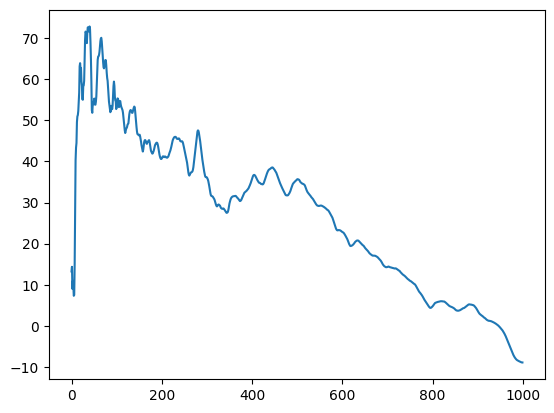

In [13]:
mean_fft = np.mean(ffts.values[:10, :], axis=0)
plt.plot(mean_fft)
mean_fft = np.tile(mean_fft, (ffts.shape[0], 1))

In [17]:
mfft_scores = mean_squared_error(mean_fft.T, ffts.T, multioutput='raw_values')
mfft_scores.shape


(140,)

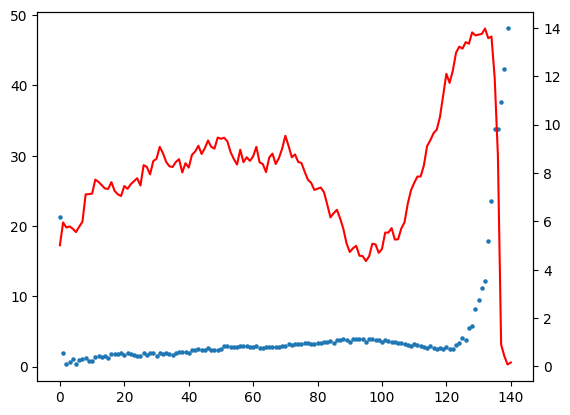

In [19]:
plt.scatter(range(len(mfft_scores)), mfft_scores, s=5)
# plt.ylim(0, 10)
plt.twinx()
plt.plot(runout, 'r')

## RMS fft

In [30]:
rms = src.ae.ae.RMS(exp)

IndexError: list index out of range

In [121]:
def remove_dc(sig):
    return sig - np.nanmean(sig)

rms._data = rms.data.iloc[50:350, :].reset_index(drop=True)
rms._data = rms.data.apply(remove_dc, axis=0)

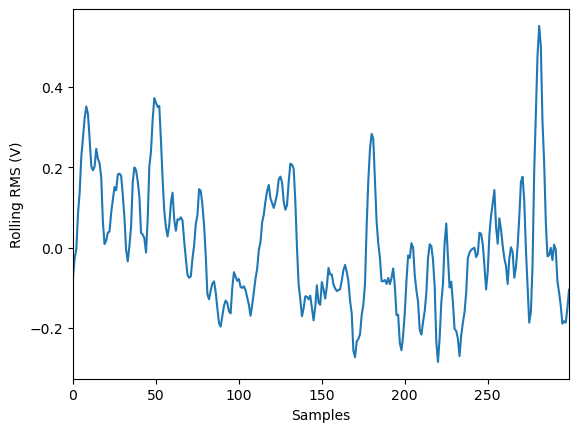

In [123]:
r = rms.data.values
r.shape
plt.plot(r[:, 43])
plt.xlabel('Samples')
plt.ylabel('Rolling RMS (V)')
plt.autoscale(enable=True, axis='x', tight=True)

In [130]:
fft = np.fft.fft(r, axis=0)
p2 = np.abs(fft/r.shape[0])
p1 = p2[1:r.shape[0]//2+1, :]
p1 = p1 * 2

In [153]:
TRAIN_STOP = 50

x_train, x_test, x_val, data_sc = pre_process(p1.T,
                                              (range(TRAIN_STOP),
                                               range(TRAIN_STOP, ffts.shape[0])
                                               ),
                                              )

In [172]:
autoe = AutoEncoder(x_train.shape[1],
                    latent_dim= 2,
                    n_size=[16],
                    dropout=0,
                    )
autoe.build_graph().summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 150)]             0         
                                                                 
 encoder (Functional)        (None, 2)                 2450      
                                                                 
 decoder (Functional)        (None, 150)               2598      
                                                                 
Total params: 5,048
Trainable params: 5,048
Non-trainable params: 0
_________________________________________________________________


In [173]:
autoe.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),)

In [174]:
history = autoe.fit(x_train, x_train,
                    validation_data=(x_test, x_test),
                    epochs=500,
                    batch_size=32,
                    )

Epoch 1/500


2/2 [==============================] - 0s 99ms/step - loss: 0.0111 - val_loss: 0.0099
Epoch 2/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0110 - val_loss: 0.0099
Epoch 3/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0110 - val_loss: 0.0099
Epoch 4/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0110 - val_loss: 0.0099
Epoch 5/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0109 - val_loss: 0.0098
Epoch 6/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0109 - val_loss: 0.0098
Epoch 7/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0109 - val_loss: 0.0098
Epoch 8/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0109 - val_loss: 0.0098
Epoch 9/500
2/2 [==============================] - 0s 32ms/step - loss: 0.0108 - val_loss: 0.0098
Epoch 10/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0108 - val_loss: 0.0097
Epoch 11/500
2/2 [=============

Text(0.5, 0, 'Epoch')

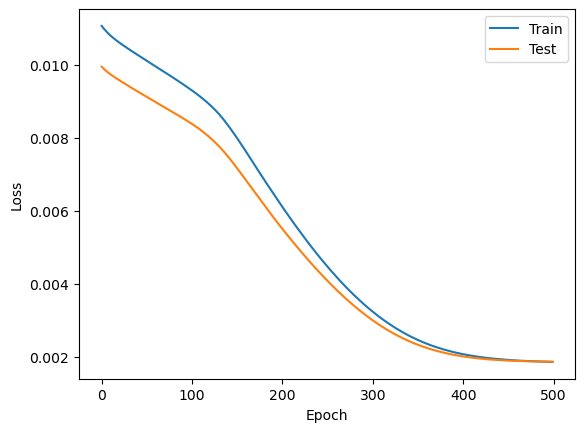

In [175]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='Train')
ax.plot(history.history['val_loss'], label='Test')
ax.legend()
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')

In [176]:
predictions = autoe.predict(data_sc)

recon_scores = mean_squared_error(data_sc.T, predictions.T, multioutput='raw_values')

7/7 [==============================] - 0s 4ms/step


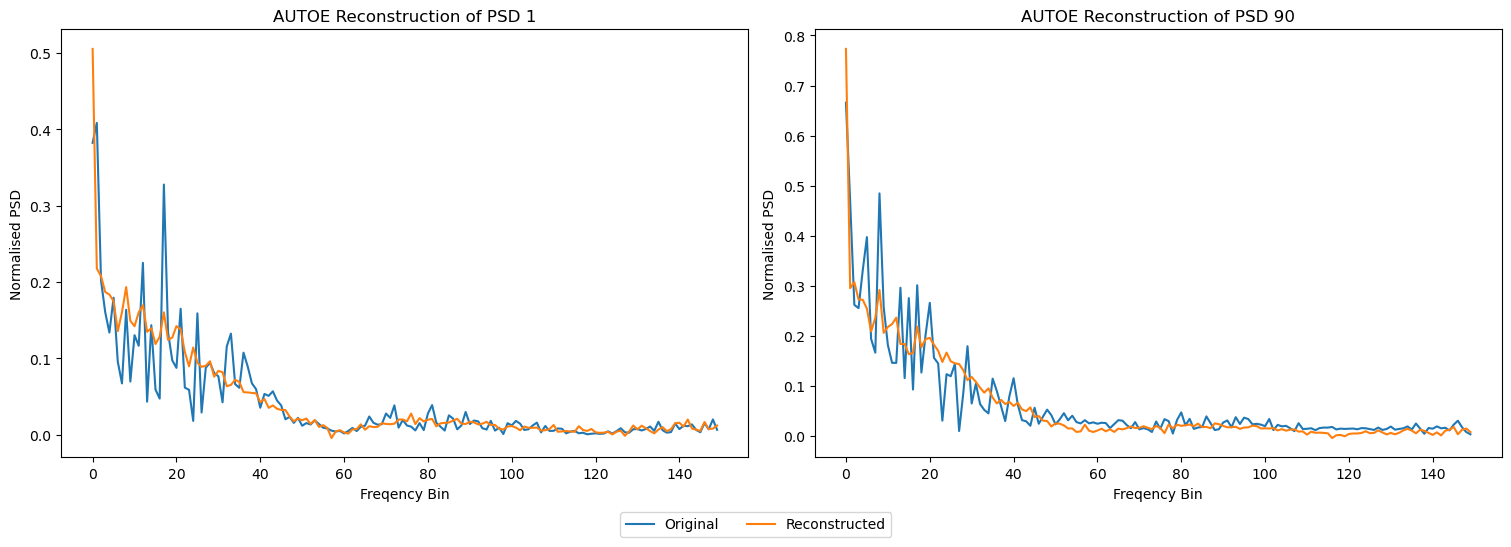

In [177]:
i = [1, 90]
pred_plot(i, data_sc, predictions)
plt.show()

In [178]:
y = recon_scores
# remove outliers
y = reject_outliers(recon_scores)

x = np.arange(len(y))

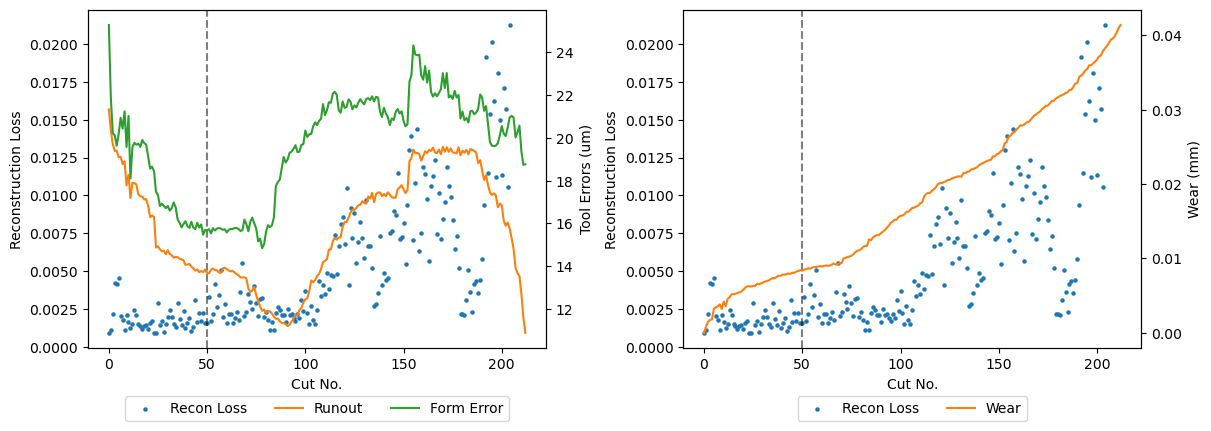

In [179]:
runout = exp_data.features['Runout'] * 1000
form_error = exp_data.features['Form error'] * 1000
mean_rad = exp_data.features['Mean radius']
wear = np.abs(mean_rad - mean_rad.iloc[0])

# line of best fit
cf  = fit_poly(x, y, 1)
lbf = np.polyval(cf, x)


fig, ax = plt.subplots(1, 2, figsize=(12, 4.2), constrained_layout=True)
ax[0].scatter(x,
              y,
              s=5,
              label='Recon Loss',
              )
# ax[0].plot(lbf, 'k--', alpha=0.5)
ax[0].axvline(TRAIN_STOP,
            color='k',
            linestyle='--',
            alpha=0.5,
            )
ax2 = ax[0].twinx()
ax2.plot(runout, 'C1', label='Runout')
ax2.plot(form_error, 'C2', label='Form Error')

ax[0].set_ylabel('Reconstruction Loss')
ax2.set_ylabel('Tool Errors (um)')
ax[0].set_xlabel('Cut No.')

lines, labels = ax[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax[0].legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=len(lines+lines2))

# wear plot
ax[1].scatter(x,
              y,
              s=5,
              label='Recon Loss',
              )
# ax[1].plot(lbf, 'k--', alpha=0.5)
ax[1].axvline(TRAIN_STOP,
            color='k',
            linestyle='--',
            alpha=0.5,
            )
ax3= ax[1].twinx()
ax3.plot(wear, 'C1', label='Wear')

ax[1].set_ylabel('Reconstruction Loss')
ax3.set_ylabel('Wear (mm)')
ax[1].set_xlabel('Cut No.')

lines, labels = ax[1].get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
ax[1].legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=len(lines+lines2))

# ax[0].set_ylim(0.000, 0.0012)
# ax[1].set_ylim(0.000, 0.0012)

plt.show()

7/7 [==============================] - 0s 3ms/step


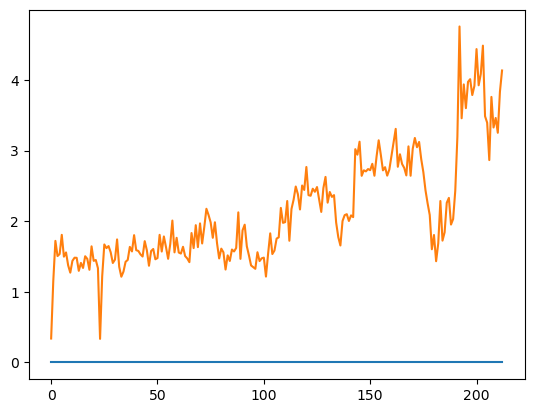

In [180]:
encoder = autoe.get_layer('encoder')
en_data = encoder.predict(data_sc)
plt.plot(en_data)

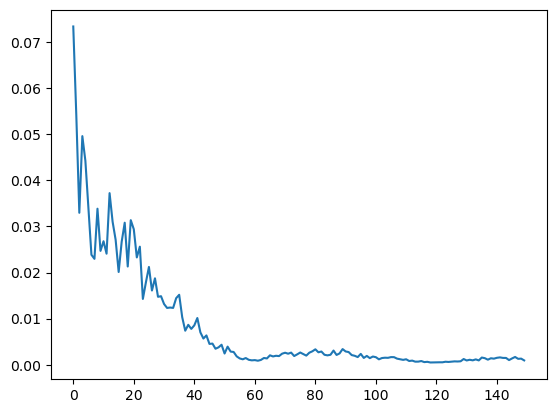

In [181]:
mean_rms = np.mean(p1.T[:10, :], axis=0)
plt.plot(mean_rms)
mean_rms = np.tile(mean_rms, (p1.T.shape[0], 1))

In [184]:
mrms_scores = mean_squared_error(mean_rms.T, p1, multioutput='raw_values')
mrms_scores.shape

(213,)

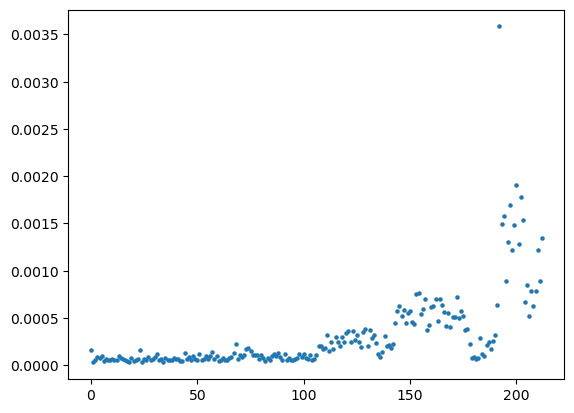

In [185]:
plt.scatter(range(len(mrms_scores)), mrms_scores, s=5)